# Global-scale atmospheric moisture and mass budgets on ERA5 pressure level data

In [1]:
import numpy as np
import xarray as xr

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
base_dir = '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/'
filename = base_dir + 'static/ERA5_plevel_1deg_6h_conserve_static.zarr'
ds_static = xr.open_zarr(filename)

base_dir = '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/'
filename = base_dir + 'all_in_one/ERA5_plevel_1deg_6h_2020_conserve.zarr'
ds_ERA5 = xr.open_zarr(filename)

In [4]:
ds_ERA5 = ds_ERA5.isel(time=slice(0, 5))

In [5]:
R = 6371000  # m
GRAVITY = 9.80665
RHO_WATER = 1000.0 # kg/m^3
RAD_EARTH = 6371000 # m
LH_WATER = 2.26e6  # J/kg
CP_DRY = 1005 # J/kg K
CP_VAPOR = 1846 # J/kg K

In [6]:
x = ds_ERA5['longitude']
y = ds_ERA5['latitude']
lon, lat = np.meshgrid(x, y)
level_p = 100*np.array(ds_static['level'])

In [7]:
level_p # Pa or kg/m/s2

array([   100.,    200.,    300.,    500.,    700.,   1000.,   2000.,
         3000.,   5000.,   7000.,  10000.,  12500.,  15000.,  17500.,
        20000.,  22500.,  25000.,  30000.,  35000.,  40000.,  45000.,
        50000.,  55000.,  60000.,  65000.,  70000.,  75000.,  77500.,
        80000.,  82500.,  85000.,  87500.,  90000.,  92500.,  95000.,
        97500., 100000.], dtype=float32)

In [8]:
# level_diff = np.diff(level_p)
# level_diff_cumsum = np.concatenate(([0], np.cumsum(level_diff)))

In [11]:
# replace to ERA5
q = ds_ERA5['specific_total_water'].values
T = ds_ERA5['T'].values
u = ds_ERA5['U'].values
v = ds_ERA5['V'].values
precip = ds_ERA5['total_precipitation'].values
evapor = ds_ERA5['evaporation'].values
TOA_net = ds_ERA5['top_net_solar_radiation'].values
OLR = ds_ERA5['top_net_thermal_radiation'].values
R_short = ds_ERA5['surface_net_solar_radiation'].values
R_long = ds_ERA5['surface_net_thermal_radiation'].values
LH = ds_ERA5['surface_latent_heat_flux'].values
SH = ds_ERA5['surface_sensible_heat_flux'].values
GPH_surf = ds_static['geopotential_at_surface'].values

N_seconds = 3600 * 6 # 6 hourly data

In [12]:
def weighted_sum(data, weights, axis, keepdims=False):
    '''
    Compute the weighted sum of a given quantity

    Args:
        data: the quantity to be sum-ed
        weights: weights that can be broadcasted to the shape of data
        axis: dims to compute the sum
        keepdims: keepdims

    Returns:
        weighted sum
    '''
    expanded_weights = np.broadcast_to(weights, data.shape)
    return np.sum(data * expanded_weights, axis=axis, keepdims=keepdims)

def pressure_integral(q, level_p, output_shape):
    '''
    Compute the pressure level integral of a given quantity using np.trapz

    Args:
        q: the quantity with dims of (level, lat, lon) or (time, level, lat, lon)
        level_p: the pressure level of q as [Pa] and with dims of (level,)
        output_shape: either (lat, lon) or (time, lat, lon)

    Returns:
        Pressure level integrals of q
    '''
    # Ensure level_p is a NumPy array
    level_p = np.asarray(level_p)

    # (level, lat, lon) --> (lat, lon)
    if len(output_shape) == 2 and q.ndim == 3:
        Q = np.trapz(q, x=level_p, axis=0)

    # (time, level, lat, lon) --> (time, lat, lon)
    elif len(output_shape) == 3 and q.ndim == 4:
        Q = np.trapz(q, x=level_p, axis=1)

    else:
        raise ValueError('Invalid output_shape or dimensions of q.')

    return Q

def grid_area(lat, lon):
    '''
    Compute grid cell areas using the exact formula for spherical quadrilaterals.

    Args:
        lat, lon: 2D arrays of latitude and longitude in degrees.

    Return:
        area: 2D array of grid cell areas in square meters.
    '''
    # Convert latitude and longitude to radians
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)
    
    # Compute sine of latitude
    sin_lat_rad = np.sin(lat_rad)
    
    # Compute gradient of sine of latitude (d_phi)
    d_phi = np.gradient(sin_lat_rad, axis=0, edge_order=2)
    
    # Compute gradient of longitude (d_lambda)
    d_lambda = np.gradient(lon_rad, axis=1, edge_order=2)
    
    # Adjust d_lambda to be within -π and π
    d_lambda = (d_lambda + np.pi) % (2 * np.pi) - np.pi
    
    # Compute grid cell area
    area = np.abs(RAD_EARTH**2 * d_phi * d_lambda)
    
    return area

area = grid_area(lat, lon)
w_lat = area #/ np.sum(area)

In [13]:
output_shape = (q.shape[0],)+lon.shape

def mass_residual_compute(q, level_p, output_shape, w_lat):
    mass_dry_per_area = pressure_integral(1-q, level_p, output_shape) / GRAVITY
    mass_dry_sum = weighted_sum(mass_dry_per_area, w_lat, axis=(1, 2), keepdims=False)
    # ----------------------------------------------------------------------- #
    # check residual term
    mass_dry_res = np.diff(mass_dry_sum)
    return mass_dry_res


In [14]:
mass_residual = mass_residual_compute(q, level_p, output_shape, w_lat)

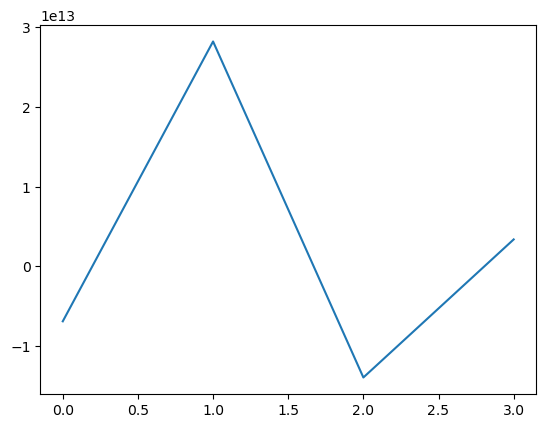

In [15]:
plt.plot(mass_residual)

In [16]:
#def water_budget_compute(q, precip, evapor, N_seconds, output_shape, w_lat):

precip_flux = precip_ERA5[1:, ...] * RHO_WATER / N_seconds # m/hour --> kg/m^2/s, positive
evapor_flux = evapor_ERA5[1:, ...] * RHO_WATER / N_seconds # kg/m^2/s, negative

# pre-compute TWC
TWC = pressure_integral(q, level_p, output_shape) / GRAVITY # kg/m^2
dTWC_dt = np.diff(TWC, axis=0) / N_seconds # kg/m^2/s
TWC_sum = weighted_sum(dTWC_dt, w_lat, axis=(1, 2), keepdims=False) # kg/s

# pre-compute evaporation
E_sum = weighted_sum(evapor_flux, w_lat, axis=(1, 2), keepdims=False) # kg/s


P_sum = weighted_sum(precip_flux, w_lat, axis=(1, 2), keepdims=False) # kg/s

residual = -TWC_sum - E_sum - P_sum

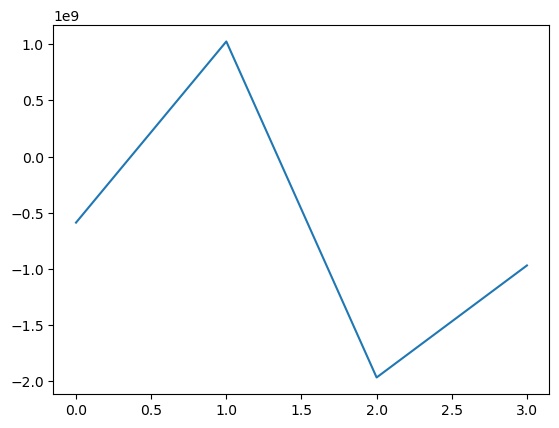

In [17]:
plt.plot(residual)

In [24]:
N_seconds = 3600 * 6 # 6 hourly data

C_p = (1 - q) * CP_DRY + q * CP_VAPOR

ken = 0.5 * (u ** 2 + v ** 2)

E_qgk = LH_WATER * q + GPH_surf + ken


R_T = (TOA_net + OLR) / N_seconds
R_T = R_T[1:, :, :]
R_T_sum = weighted_sum(R_T, area, axis=(-2, -1))

F_S = (R_short + R_long + LH + SH) / N_seconds
F_S = F_S[1:, :, :]
F_S_sum = weighted_sum(F_S, area, axis=(-2, -1))

# layer-wise atmospheric energy (sensible heat + others)
E_level = C_p * T + E_qgk

# total atmospheric energy (TE) of an air column
TE = pressure_integral(E_level, level_p, output_shape) / GRAVITY

# ---------------------------------------------------------------------------- #
# tendency of TE
dTE_dt = (TE[1:, :, :] - TE[:-1, :, :]) / N_seconds
# global sum of TE tendency
dTE_sum = weighted_sum(dTE_dt, area, axis=(1, 2))
# compute the residual
residual = (R_T_sum - F_S_sum) - dTE_sum

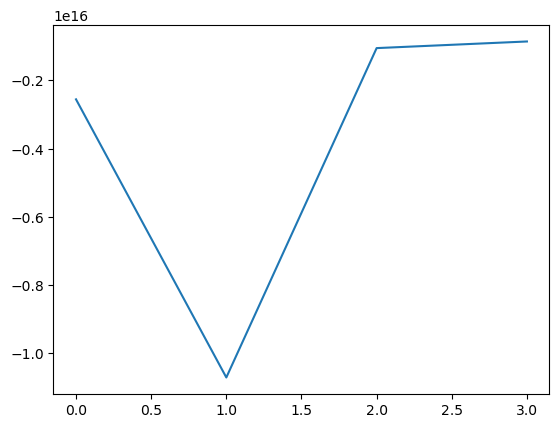

In [25]:
plt.plot(residual)

In [ ]:
plt.plot(residual)